# Car Price prediction

<img src="https://whatcar.vn/media/2018/09/car-lot-940x470.jpg"/>

<span style="color:teal;">
    
## Прогнозирование стоимости автомобиля по характеристикам
*Этот ноутбук является шаблоном (Baseline) к текущему соревнованию и не служит готовым решением!*   
Вы можете использовать его как основу для построения своего решения.


> **Baseline** создается больше как шаблон, где можно посмотреть, как происходит обращение с входящими данными и что нужно получить на выходе. При этом ML начинка может быть достаточно простой. Это помогает быстрее приступить к самому ML, а не тратить ценное время на инженерные задачи. 
Также baseline является хорошей опорной точкой по метрике. Если наше решение хуже baseline -  мы явно делаем что-то не так и стоит попробовать другой путь) 
    
</span>

<span style="color:teal;">
    
## В baseline мы сделаем следующее:
* Построим "наивную"/baseline модель, предсказывающую цену по модели и году выпуска (с ней будем сравнивать другие модели)
* Обработаем и отнормируем признаки
* Сделаем первую модель на основе градиентного бустинга с помощью CatBoost
* Сделаем вторую модель на основе нейронных сетей и сравним результаты
* Сделаем multi-input нейронную сеть для анализа табличных данных и текста одновременно
* Добавим в multi-input сеть обработку изображений
* Осуществим ансамблирование градиентного бустинга и нейронной сети (усреднение их предсказаний)

</span>

# Настройки, библиотеки, функции

In [1]:
!pip install -q tensorflow==2.3

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
#аугментации изображений
!pip install albumentations -q

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [3]:
!pip install -U efficientnet

     |████████████████████████████████| 50 kB 3.0 MB/s 
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [4]:
import efficientnet.tfkeras as efn
from tensorflow.keras.applications import EfficientNetB7
from keras.applications.densenet import DenseNet169
from keras.applications import inception_resnet_v2

In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import sys
import PIL
import cv2
import re

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pickle

# # keras
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence

from tensorflow.keras.callbacks import Callback
from tensorflow.keras.regularizers import l2
from tensorflow.keras import optimizers

from keras.models import load_model

from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint,EarlyStopping, ReduceLROnPlateau
import albumentations

# plt
import matplotlib.pyplot as plt
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

import string
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import RussianStemmer
from nltk.corpus import stopwords, words

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [6]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)

Python       : 3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 23:03:20) 
Numpy        : 1.18.5
Tensorflow   : 2.3.0


In [7]:
# Воспроизводимость результатов
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Доля валидации
VAL_SIZE = 0.2

# Размер картинок
SIZE = (320, 240)

In [8]:
!pip freeze > requirements.txt

In [9]:
# Функция для оценки предсказания
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

# Функция для вывода графика обучения
def plot_history(history):
    plt.title('Loss')
    plt.plot(history.history['MAPE'], label='train')
    plt.plot(history.history['val_MAPE'], label='test')
    plt.show()

# Данные

Посмотрим на типы признаков:

* bodyType - категориальный
* brand - категориальный
* color - категориальный
* description - текстовый
* engineDisplacement - числовой, представленный как текст
* enginePower - числовой, представленный как текст
* fuelType - категориальный
* mileage - числовой
* modelDate - числовой
* model_info - категориальный
* name - категориальный, желательно сократить размерность
* numberOfDoors - категориальный
* price - числовой, целевой
* productionDate - числовой
* sell_id - изображение (файл доступен по адресу, основанному на sell_id)
* vehicleConfiguration - не используется (комбинация других столбцов)
* vehicleTransmission - категориальный
* Владельцы - категориальный
* Владение - числовой, представленный как текст
* ПТС - категориальный
* Привод - категориальный
* Руль - категориальный

In [10]:
DATA_DIR = '../input/sf-dst-car-price-prediction-part2/'
train = pd.read_csv(DATA_DIR + 'train.csv')
test = pd.read_csv(DATA_DIR + 'test.csv')
sample_submission = pd.read_csv(DATA_DIR + 'sample_submission.csv')

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6682 entries, 0 to 6681
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              6682 non-null   object 
 1   brand                 6682 non-null   object 
 2   color                 6682 non-null   object 
 3   description           6682 non-null   object 
 4   engineDisplacement    6682 non-null   object 
 5   enginePower           6682 non-null   object 
 6   fuelType              6682 non-null   object 
 7   mileage               6682 non-null   int64  
 8   modelDate             6682 non-null   int64  
 9   model_info            6682 non-null   object 
 10  name                  6682 non-null   object 
 11  numberOfDoors         6682 non-null   int64  
 12  price                 6682 non-null   float64
 13  productionDate        6682 non-null   int64  
 14  sell_id               6682 non-null   int64  
 15  vehicleConfiguration 

In [12]:
train.nunique()

bodyType                  17
brand                      3
color                     16
description             6147
engineDisplacement        48
enginePower              146
fuelType                   4
mileage                 2900
modelDate                 41
model_info               118
name                     900
numberOfDoors              4
price                   1628
productionDate            38
sell_id                 6682
vehicleConfiguration     288
vehicleTransmission        4
Владельцы                  3
Владение                 173
ПТС                        2
Привод                     3
Руль                       2
dtype: int64

# Model 1: "Наивная" модель 
Эта модель будет предсказывать среднюю цену по модели и году выпуска. 
C ней будем сравнивать другие модели.



In [13]:
# Разбиваем данные
data_train, data_test = train_test_split(train, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [14]:
# Наивная модель
predicts = []
for index, row in pd.DataFrame(data_test[['model_info', 'productionDate']]).iterrows():
    query = f"model_info == '{row[0]}' and productionDate == '{row[1]}'"
    predicts.append(data_train.query(query)['price'].median())

# Заполняем ненайденные совпадения
predicts = pd.DataFrame(predicts)
predicts = predicts.fillna(predicts.median())

# Округляем
predicts = (predicts // 1000) * 1000

# Оцениваем точность
print(f"Точность наивной модели по метрике MAPE: {(mape(data_test['price'], predicts.values[:, 0]))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 19.88%


# EDA и подготовка данных

Анализ и очистка данных были проведены в другом ноутбуке. Там же были попробованы разные модели регрессии для предсказания.   
Загрузим очищенные данные, на которых проводилась проверка регрессии.

In [15]:
# В этом наборе лежат подготовленные признаки из train и test одновременно. Различаются они по отметке 'sample'.
df1 = pd.read_csv('../input/car-data-clean/df_clean1.csv')
df2 = pd.read_csv('../input/car-data-clean/df_clean2.csv')

In [16]:
# Здесь лежат статистические параметры
df2.columns, df2.shape

(Index(['price', 'sample', 'sell_id', 'mean_model_info_price',
        'median_model_info_price', 'max_model_info_price',
        'min_model_info_price', 'std_model_info_price', 'mean_bodyType_price',
        'median_bodyType_price',
        ...
        'mean_vehicleTransmission_age_log',
        'median_vehicleTransmission_age_log', 'max_vehicleTransmission_age_log',
        'min_vehicleTransmission_age_log', 'std_vehicleTransmission_age_log',
        'mean_body_age_log', 'median_body_age_log', 'max_body_age_log',
        'min_body_age_log', 'std_body_age_log'],
       dtype='object', length=283),
 (8353, 283))

In [17]:
# Здесь лежат очищенные исходные параметры и сгенерированные на их основе дополнительные признаки
df1.columns, df1.shape

(Index(['ПТС', 'color_type', 'eD_log_out', 'drive', 'long', 'exState',
        'goodState', 'noSmoke', 'dent', 'salon', 'carter', 'electro-window',
        'airbag', 'wheel-power', 'lock', 'help', 'climate', 'cruise',
        'computer', 'heat', 'electro-mirrors', 'ptf', 'abs', 'esp', 'condition',
        'immo', 'alarm', 'navigation', 'park', 'audio', 'rain-sensor',
        'alloy-wheel-disks', 'camera', 'tyre-pressure', 'dark', 'asr',
        'Владельцы', 'tax_rate', 'eP_log', 'eD_log', 'mileage_norm_log',
        'milPerYear', 'model_age_log', 'age_log', 'model_old_log',
        'own_num_log', 'desc_polarity', 'desc_subjectivity', 'desc_mean_log',
        'desc_len_log', 'tfidf1', 'tfidf2', 'bodyType', 'brand', 'color',
        'fuelType', 'model_info', 'numberOfDoors', 'vehicleTransmission',
        'body', 'price', 'sample', 'sell_id'],
       dtype='object'),
 (8353, 63))

In [18]:
df = df1.merge(df2, on=['sell_id', 'sample', 'price'], how='inner')
df.shape

(8353, 343)

Сохраним очищенные признаки в списки разных типов.

In [19]:
# Двоичные признаки 
bin_columns = ['ПТС', 'color_type','eD_log_out', 'drive', 'long', 
       'exState', 'goodState', 'noSmoke', 'dent', 'salon', 'carter',
       'electro-window', 'airbag', 'wheel-power', 'lock', 'help', 'climate',
       'cruise', 'computer', 'heat', 'electro-mirrors', 'ptf', 'abs', 'esp',
       'condition', 'immo', 'alarm', 'navigation', 'park', 'audio',
       'rain-sensor', 'alloy-wheel-disks', 'camera', 'tyre-pressure',
       'dark', 'asr']

# Числовые признаки
num_columns = ['Владельцы','tax_rate','eP_log', 'eD_log', 
       'mileage_norm_log', 'milPerYear', 'model_age_log', 'age_log', 'model_old_log',
       'own_num_log', 'desc_polarity', 'desc_subjectivity', 
       'desc_mean_log', 'desc_len_log', 'tfidf1', 'tfidf2']

# Категориальные признаки
cat_columns = ['bodyType', 'brand', 'color', 'fuelType', 'model_info', 
       'numberOfDoors', 'vehicleTransmission', 'body']

# Служебные признаки
srv_columns = ['price', 'sample', 'sell_id']

# Статистические числовые признаки
stat_columns = list(df2.columns[3:])

# Все признаки
columns = bin_columns + num_columns + cat_columns + srv_columns + stat_columns

In [20]:
# Категориальные признаки заменяем на dummy
data = df[columns].copy()
data = pd.get_dummies(data, columns=cat_columns, dummy_na=False)

In [21]:
# Разбиваем данные для обучения и проверки
X = data[data['sample'] == 1].drop(['sample','price','sell_id'], axis=1)
X_sub = data[data['sample'] == 0].drop(['sample','price','sell_id'], axis=1)
y = data[data['sample'] == 1]['price']
X.shape, len(y)

((6682, 513), 6682)

In [22]:
# Разбиваем тренировочный набор для обучения
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

# Model 2: CatBoost + RandomForest + XGB

Взяты эти три модели как показавшие себя лучше прочих при проверке очищенных данных в другом ноутбуке.

## Обучение моделей регрессии

In [23]:
# Модель с параметрами по умолчанию 
RandF = RandomForestRegressor(random_state=RANDOM_SEED)

# Обучаем модель на тестовом наборе данных
RandF.fit(X_train, np.log(y_train))
pred_RandF_tt = RandF.predict(X_test)

# Преобразуем y_test, y_pred к exp значениям для оценки MAPE

pred_RandF_tt = np.round(np.exp(pred_RandF_tt))

# Вывод результата MAPE
print(f"Точность обученной модели по метрике MAPE: {(mape(y_test, pred_RandF_tt))*100:0.2f}%")

Точность обученной модели по метрике MAPE: 11.67%


In [24]:
# Прикинем разумность предсказания
pred_RandF_tr = np.exp(RandF.predict(X_train))
pred_RandF_sub = np.exp(RandF.predict(X_sub))
sample_submission['price'] = pred_RandF_sub
sample_submission.head()

,sell_id,price
0,1099427284,5.869432e+05
1,1096405886,2.343178e+06
2,1100195294,6.842258e+05
3,1099827282,5.067114e+05
4,1100076198,2.670607e+06


In [25]:
# Теперь обучим на полных данных
RandF = RandomForestRegressor(random_state=RANDOM_SEED)
RandF.fit(X, np.log(y))
pred_RandF_tt = np.exp(RandF.predict(X_test))

# Вывод результата MAPE
print(f"Точность обученной модели по метрике MAPE: {(mape(y_test, pred_RandF_tt))*100:0.2f}%")

Точность обученной модели по метрике MAPE: 4.21%


Подбор гиперпараметров для данной модели не уменьшил ошибку. Поэтому оставлено с параметрами по умолчанию.

In [26]:
# Сохраним предсказания для дальнейшего использования в ансамбле с нейронными сетями
pred_RandF_tr = np.exp(RandF.predict(X_train))
pred_RandF_sub = np.exp(RandF.predict(X_sub))
sample_submission['price'] = pred_RandF_sub
sample_submission.head()

,sell_id,price
0,1099427284,5.828374e+05
1,1096405886,2.252696e+06
2,1100195294,6.866360e+05
3,1099827282,4.951440e+05
4,1100076198,2.654112e+06


In [27]:
# CatBt = CatBoostRegressor(iterations = 5000,
#                           random_seed = RANDOM_SEED,
#                           eval_metric='MAPE',
#                           custom_metric=['R2', 'MAE'],
#                           silent=True,
#                          )
# CatBt.fit(X_train, np.log(y_train),
#          #cat_features=cat_features_ids,
#          eval_set=(X_test, np.log(y_test)),
#          verbose_eval=0,
#          use_best_model=True,
#          #plot=True
#          )

# pred_CatBt_tt = np.exp(CatBt.predict(X_test))
# print(f"Точность модели по метрике MAPE: {(mape(y_test, pred_CatBt_tt))*100:0.2f}%")
# Без подбора параметров точность = 11.16%

Без подбора параметров точность получалась 11.16%

In [28]:
CatBt = CatBoostRegressor(iterations = 5000,              
                            learning_rate = 0.05,           
                            l2_leaf_reg = 2,                
                            depth = 7,                      
                            random_strength = 0.5,          
                            random_seed = RANDOM_SEED,     
                            eval_metric = 'MAPE',           
                            custom_metric=['R2', 'MAE'],
                         )
CatBt.fit(X_train, np.log(y_train),
         #cat_features=cat_features_ids,
         eval_set=(X_test, np.log(y_test)),
         verbose_eval=0,
         use_best_model=True,
         #plot=True
         )

pred_CatBt_tt = np.exp(CatBt.predict(X_test))
print(f"Точность модели по метрике MAPE: {(mape(y_test, pred_CatBt_tt))*100:0.2f}%")

Точность модели по метрике MAPE: 11.04%


С подбором гиперпараметров метрика уменьшилась до 11.04%

In [29]:
# Прикинем разумность предсказания
pred_CatBt_tr = np.exp(CatBt.predict(X_train))
pred_CatBt_sub = np.exp(CatBt.predict(X_sub))
sample_submission['price'] = pred_CatBt_sub
sample_submission.head()

,sell_id,price
0,1099427284,6.332680e+05
1,1096405886,2.666343e+06
2,1100195294,6.960924e+05
3,1099827282,4.638327e+05
4,1100076198,2.781541e+06


In [30]:
# Теперь обучим на полных данных
CatBt = CatBoostRegressor(iterations = 5000,              
                            learning_rate = 0.05,           
                            l2_leaf_reg = 2,                
                            depth = 7,                      
                            random_strength = 0.5,          
                            random_seed = RANDOM_SEED,     
                            eval_metric = 'MAPE',           
                            custom_metric=['R2', 'MAE'],
                         )
CatBt.fit(X, np.log(y),
         eval_set=(X_test, np.log(y_test)),
         verbose_eval=0,
         use_best_model=True,
         )

pred_CatBt_tt = np.exp(CatBt.predict(X_test))
print(f"Точность модели по метрике MAPE: {(mape(y_test, pred_CatBt_tt))*100:0.2f}%")

Точность модели по метрике MAPE: 1.51%


Обучение на полных данных существенно улучшило результат на сабмите.

In [31]:
# Сохраним предсказания для дальнейшего использования в ансамбле с нейронными сетями
pred_CatBt_tr = np.exp(CatBt.predict(X_train))
pred_CatBt_sub = np.exp(CatBt.predict(X_sub))
sample_submission['price'] = pred_CatBt_sub
sample_submission.head()

,sell_id,price
0,1099427284,6.165189e+05
1,1096405886,2.661345e+06
2,1100195294,6.945748e+05
3,1099827282,4.893850e+05
4,1100076198,2.659579e+06


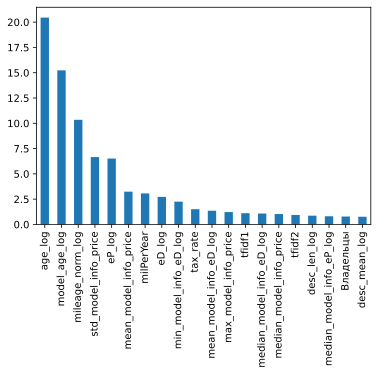

In [32]:
# Найдем самые полезные для модели признаки
CatBt_features = pd.Series(CatBt.feature_importances_,index=X_train.columns).sort_values(ascending=False)
CatBt_features.iloc[:20].plot(kind='bar')

In [33]:
CatBt_features = CatBt_features.iloc[:5].index
CatBt_features

Index(['age_log', 'model_age_log', 'mileage_norm_log', 'std_model_info_price',
       'eP_log'],
      dtype='object')

Видно, что с отрывом лидируют 5 признаков: 'age_log', 'model_age_log', 'mileage_norm_log', 'std_model_info_price',
       'eP_log'

In [34]:
# XGB_R = xgb.XGBRegressor()
# XGB_R.fit(X_train, np.log(y_train))

# pred_XGB_R_tt = np.exp(XGB_R.predict(X_test))
# print(f"Точность модели по метрике MAPE: {(mape(y_test, pred_XGB_R_tt))*100:0.2f}%")

Без подбора гиперпараметров метрика составляла 12.30%

In [35]:
# # Подбор параметров для XGB
# from sklearn.model_selection import GridSearchCV
# param_grid = {'nthread':[4], #when use hyperthread, xgboost may become slower
#               'objective':['reg:squarederror'],
#               'learning_rate': [0.03, 0.05, 0.07], 
#               'max_depth': [10, 12, 14],
#               'alpha': [0, 1],
#               'colsample_bytree': [0.3, 0.5, 0.7],
#               'n_estimators': [1000]}

# xgbRegr = xgb.XGBRegressor()
# grid_search_result = GridSearchCV(xgbRegr,
#                         param_grid,
#                         cv = 2,
#                         n_jobs = -1,
#                         verbose=True)

# grid_search_result.fit(X_train, y_train)
# print(grid_search_result.best_params_)

# 'alpha': 1, 
# 'colsample_bytree': 0.5, 
# 'learning_rate': 0.05, 
# 'max_depth': 10, 
# 'n_estimators': 1000, 
# 'nthread': 4, 
# 'objective': 'reg:squarederror'

In [36]:
XGB_R = xgb.XGBRegressor(
    alpha= 1, 
    colsample_bytree=0.5, 
    learning_rate=0.05, 
    max_depth=10, 
    n_estimators=1000, 
    nthread=4, 
    objective='reg:squarederror'
)
XGB_R.fit(X_train, np.log(y_train))

pred_XGB_R_tt = np.exp(XGB_R.predict(X_test))
print(f"Точность модели по метрике MAPE: {(mape(y_test, pred_XGB_R_tt))*100:0.2f}%")

Точность модели по метрике MAPE: 11.27%


Подбор гиперпараметров существенно улучшил метрику.

In [37]:
# Прикинем разумность предсказания
pred_XGB_R_tr = np.exp(CatBt.predict(X_train))
pred_XGB_R_sub = np.exp(CatBt.predict(X_sub))
sample_submission['price'] = pred_XGB_R_sub
sample_submission.head()

,sell_id,price
0,1099427284,6.165189e+05
1,1096405886,2.661345e+06
2,1100195294,6.945748e+05
3,1099827282,4.893850e+05
4,1100076198,2.659579e+06


In [38]:
# Теперь обучим на полных данных
XGB_R = xgb.XGBRegressor(
    alpha= 1, 
    colsample_bytree=0.5, 
    learning_rate=0.05, 
    max_depth=10, 
    n_estimators=1000, 
    nthread=4, 
    objective='reg:squarederror'
)
XGB_R.fit(X, np.log(y))

pred_XGB_R_tt = np.exp(XGB_R.predict(X_test))
print(f"Точность модели по метрике MAPE: {(mape(y_test, pred_XGB_R_tt))*100:0.2f}%")

Точность модели по метрике MAPE: 3.58%


In [39]:
# Сохраним предсказания для дальнейшего использования в ансамбле с нейронными сетями
pred_XGB_R_tr = np.exp(CatBt.predict(X_train))
pred_XGB_R_sub = np.exp(CatBt.predict(X_sub))
sample_submission['price'] = pred_XGB_R_sub
sample_submission.head()

,sell_id,price
0,1099427284,6.165189e+05
1,1096405886,2.661345e+06
2,1100195294,6.945748e+05
3,1099827282,4.893850e+05
4,1100076198,2.659579e+06


## Ансамбль моделей регрессии

In [40]:
# Составим обучающие мета-данные для линейной регрессии
meta_train = np.hstack([
    pred_RandF_tr.reshape(-1,1),
    pred_CatBt_tr.reshape(-1,1),
    pred_XGB_R_tr.reshape(-1,1)
])

meta_test = np.hstack([
    pred_RandF_tt.reshape(-1,1),
    pred_CatBt_tt.reshape(-1,1),
    pred_XGB_R_tt.reshape(-1,1)
])

print(len(meta_train), len(y_train))

5345 5345


In [41]:
# Мета-модель для комбинации предсказаний
meta_CatBt = CatBoostRegressor(iterations = 5000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                         )
meta_CatBt.fit(meta_train, np.log(y_train),
         verbose_eval=0
         #plot=True
         )

meta_test_predict = np.exp(meta_CatBt.predict(meta_test))
print(f"Точность модели по метрике MAPE: {(mape(y_test, meta_test_predict))*100:0.2f}%")

coeff = meta_CatBt.feature_importances_/100
coeff

Точность модели по метрике MAPE: 2.55%


array([0.26303773, 0.37553633, 0.36142593])

In [42]:
# Делаем сабмит на моделях регрессии
predict_submission1 = (pred_RandF_sub + pred_CatBt_sub + pred_XGB_R_sub)/3

# Применим коэффициенты из мета-модели
predict_submission2 = coeff[0]*pred_RandF_sub + coeff[1]*pred_CatBt_sub + coeff[2]*pred_XGB_R_sub

sample_submission['price'] = predict_submission1
sample_submission.to_csv('submission_regr_mean.csv', index=False)
display(sample_submission.head(10))

sample_submission['price'] = predict_submission2
sample_submission.to_csv('submission_regr_model.csv', index=False)
display(sample_submission.head(10))

,sell_id,price
0,1099427284,6.052918e+05
1,1096405886,2.525129e+06
2,1100195294,6.919285e+05
3,1099827282,4.913047e+05
4,1100076198,2.657757e+06
5,1090159352,3.099969e+06
6,1098987386,1.547786e+06
7,1098639040,1.465177e+06
8,1099933039,1.115517e+06
9,1099565572,5.035688e+05


,sell_id,price
0,1099427284,6.076594e+05
1,1096405886,2.553855e+06
2,1100195294,6.924866e+05
3,1099827282,4.908999e+05
4,1100076198,2.658141e+06
5,1090159352,3.110440e+06
6,1098987386,1.549074e+06
7,1098639040,1.475356e+06
8,1099933039,1.111526e+06
9,1099565572,5.002720e+05


Точность по метрике MAPE на ансамбле моделей вышла лучше, чем по отдельности.   
Для простого среднего 10.98%    
Для взвешенной суммы  10.87%   
На сабмите взвешенной суммы получилось около 11.16%


# Model 3: Tabular NN

## Подготовка данных для Tabular NN

In [43]:
# Из обработки исключим статистические признаки. С ними сеть обучалась очень плохо
dataNN = df[num_columns+cat_columns+srv_columns].copy()
dataNN = pd.get_dummies(dataNN, columns=cat_columns, dummy_na=False)

# Снова разбиваем данные
X = dataNN[dataNN['sample'] == 1].drop(['sample','price','sell_id'], axis=1)
X_sub = dataNN[dataNN['sample'] == 0].drop(['sample','price','sell_id'], axis=1)
y = dataNN[dataNN['sample'] == 1]['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

In [44]:
# Почему-то штатная нормализация тоже дала не очень хороший результат
# Зато такая обработка резко улучшила метрику
mean = X_train[num_columns].mean(axis=0)
std = X_train[num_columns].std(axis=0)

X_train[num_columns] -= mean
X_train[num_columns] /= std

X_test[num_columns] -= mean
X_test[num_columns] /= std

mean = X_sub[num_columns].mean(axis=0)
std = X_sub[num_columns].std(axis=0)

X_sub[num_columns] -= mean
X_sub[num_columns] /= std

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [45]:
X_train.head(5)

,Владельцы,tax_rate,eP_log,eD_log,mileage_norm_log,milPerYear,model_age_log,age_log,model_old_log,own_num_log,...,body_компактвэн,body_купе,body_лимузин,body_лифтбек,body_минивэн,body_пикап,body_родстер,body_седан,body_универсал,body_хэтчбек
6413,1.088848,1.327208,0.353591,0.796481,0.696061,-0.211604,1.152406,1.015600,0.881250,-0.665229,...,0,0,0,0,0,0,0,1,0,0
6692,-1.317060,-0.816037,-0.729491,-0.768845,0.515549,1.224009,0.047742,-0.165649,0.881250,1.894289,...,0,0,0,0,0,0,0,1,0,0
4148,1.088848,-0.280226,-0.075279,0.341772,0.713663,-0.419874,1.273683,1.250800,0.305908,-0.665229,...,0,0,0,0,0,0,0,0,0,0
4009,1.088848,-0.494550,-0.325323,0.143750,1.303072,0.661300,1.152406,0.885952,1.327520,-0.665229,...,0,0,0,0,0,0,0,1,0,0
2470,1.088848,1.327208,1.286805,2.216108,0.015882,-0.635277,0.422458,0.746692,-1.891231,-0.665229,...,0,0,0,0,0,0,0,1,0,0


## Обучение Tabular NN

In [46]:
# Строим простую сеть
model_tnn = Sequential()
model_tnn.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model_tnn.add(L.BatchNormalization())
model_tnn.add(L.Dropout(0.4))

model_tnn.add(L.Dense(256, activation="relu"))
model_tnn.add(L.Dropout(0.4))

model_tnn.add(L.Dense(128, activation="relu"))
model_tnn.add(L.Dropout(0.4))

model_tnn.add(L.Dense(64, activation="relu"))
model_tnn.add(L.Dropout(0.4))

model_tnn.add(L.Dense(1, activation="linear"))

К базовой сети добавлен был еще один слой.   
Батч-нормализация применялась только на одном слое. Были попытки добавить ее во все слои или их часть, но тогда обучение сходилось крайне медленно - примерно за 100 эпох ошибка уменьшилась лишь до 80%. 

In [47]:
# Компилируем модель
optimizer = tf.keras.optimizers.Adam(0.01)
model_tnn.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [48]:
# Описываем callback
checkpoint = ModelCheckpoint('../working/best_model.hdf5' , monitor=['val_MAPE'], verbose=0  , mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=100, restore_best_weights=True,)
reduce_lr = ReduceLROnPlateau(monitor='val_MAPE',           
                                  factor=0.1,                
                                  patience=75,      
                                  min_lr=0.0000001,             
                                  verbose=1,              
                                  mode='min')                  
    
callbacks_list = [checkpoint, earlystop, reduce_lr]

Эксперименты с управлением шагом обучения показали, что его уменьшение в 10 раз после некоторого простоя немного уменьшали ошибку.

In [49]:
# Обучаем сеть
history = model_tnn.fit(X_train, y_train,
                    batch_size=512,
                    epochs=2000, 
                    validation_data=(X_test, y_test),
                    callbacks=callbacks_list,
                    verbose=1,
                   )

Epoch 1/2000
11/11 [==============================] - 0s 26ms/step - loss: 99.7660 - MAPE: 99.7660 - val_loss: 99.2116 - val_MAPE: 99.2116
Epoch 2/2000
11/11 [==============================] - 0s 13ms/step - loss: 87.7159 - MAPE: 87.7159 - val_loss: 74.9200 - val_MAPE: 74.9200
Epoch 3/2000
11/11 [==============================] - 0s 12ms/step - loss: 68.4560 - MAPE: 68.4560 - val_loss: 56.9802 - val_MAPE: 56.9802
Epoch 4/2000
11/11 [==============================] - 0s 12ms/step - loss: 49.5131 - MAPE: 49.5131 - val_loss: 43.5097 - val_MAPE: 43.5097
Epoch 5/2000
11/11 [==============================] - 0s 10ms/step - loss: 35.8325 - MAPE: 35.8325 - val_loss: 48.7674 - val_MAPE: 48.7674
Epoch 6/2000
11/11 [==============================] - 0s 8ms/step - loss: 29.2945 - MAPE: 29.2945 - val_loss: 57.0644 - val_MAPE: 57.0644
Epoch 7/2000
11/11 [==============================] - 0s 8ms/step - loss: 29.3983 - MAPE: 29.3983 - val_loss: 48.0746 - val_MAPE: 48.0746
Epoch 8/2000
11/11 [=========

Параметр batch_size был увеличен до 512, так это немного улучшило метрику.

In [50]:
test_predict_nn = model_tnn.predict(X_test)
print(f"TEST mape: {(mape(y_test, test_predict_nn[:,0]))*100:0.2f}%")

TEST mape: 10.95%


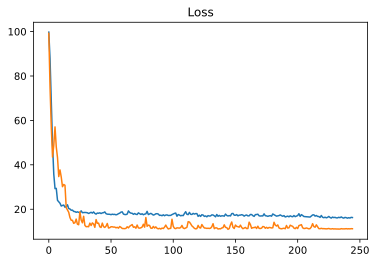

In [51]:
plot_history(history)

In [52]:
# Сохраним предсказания для дальнейшего использования в ансамбле с другими нейронными сетями моделями регрессии
pred_TabNN_tr = model_tnn.predict(X_train)
pred_TabNN_tt = model_tnn.predict(X_test)
pred_TABNN_sub = model_tnn.predict(X_sub)

# Прикинем разумность предсказания
sample_submission['price'] = pred_TABNN_sub[:,0]
sample_submission.head()

,sell_id,price
0,1099427284,7.827100e+05
1,1096405886,2.452808e+06
2,1100195294,6.087131e+05
3,1099827282,4.662286e+05
4,1100076198,2.667661e+06


## Ансамбль Tabular NN и моделей регресии

In [53]:
# Составим мета-данные для линейной регрессии
meta_train = np.hstack([
    pred_RandF_tr.reshape(-1,1),
    pred_CatBt_tr.reshape(-1,1),
    pred_XGB_R_tr.reshape(-1,1),
    pred_TabNN_tr.reshape(-1,1)
])

meta_test = np.hstack([
    pred_RandF_tt.reshape(-1,1),
    pred_CatBt_tt.reshape(-1,1),
    pred_XGB_R_tt.reshape(-1,1),
    pred_TabNN_tt.reshape(-1,1)
])

print(len(meta_train), len(y_train))

5345 5345


In [54]:
# Мета-модель для комбинации предсказаний
meta_CatBt = CatBoostRegressor(iterations = 5000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                         )
meta_CatBt.fit(meta_train, np.log(y_train),verbose_eval=0)

meta_test_predict = np.exp(meta_CatBt.predict(meta_test))
print(f"Точность модели по метрике MAPE: {(mape(y_test, meta_test_predict))*100:0.2f}%")

coeff = meta_CatBt.feature_importances_/100
coeff

Точность модели по метрике MAPE: 2.26%


array([0.22370255, 0.30830267, 0.35562962, 0.11236516])

In [55]:
# Сабмит просто сети
sample_submission['price'] = pred_TABNN_sub
sample_submission.to_csv('tabular_submission.csv', index=False)
display(sample_submission.head())

# Сабмит усредненного предсказания
predict_nn = (pred_RandF_sub + pred_CatBt_sub + pred_XGB_R_sub + pred_TABNN_sub)/4
sample_submission['price'] = predict_nn
sample_submission.to_csv('blend_mean_submission.csv', index=False)
display(sample_submission.head())

# Сабмит взвешенных предсказаний с весами из мета-модели регрессии
predict_nn = coeff[0]*pred_RandF_sub + coeff[1]*pred_CatBt_sub + coeff[2]*pred_XGB_R_sub + coeff[3]*pred_TABNN_sub
sample_submission['price'] = predict_nn
sample_submission.to_csv('blend_model_submission.csv', index=False)
display(sample_submission.head())

,sell_id,price
0,1099427284,7.827100e+05
1,1096405886,2.452808e+06
2,1100195294,6.087131e+05
3,1099827282,4.662286e+05
4,1100076198,2.667661e+06


,sell_id,price
0,1099427284,6.496463e+05
1,1096405886,1.067171e+06
2,1100195294,6.061471e+05
3,1099827282,5.705260e+05
4,1100076198,1.120884e+06


,sell_id,price
0,1099427284,627658.371061
1,1096405886,815319.222624
2,1100195294,608107.175749
3,1099827282,592096.882780
4,1100076198,839461.160124


Сабмит на простой сети без ансамблирования дал метрику 11.14%   
Сабмит с усредненным предсказанием из нейронной сети и всех моделей регресии дал 10.79%   
Сабмит с весами из мета-модели регресии, построенной на предсказаниях, дал результат 10.86%   

# Model 4: NLP + Multiple Inputs

## Подготовка данных для NLP

В очищенных данных был исключен признак description. Восстановим его из train и test.

In [56]:
# Выделяем описание автомобиля 
train['sample'] = 1 
test['sample'] = 0 
test['price'] = 0 
desc_columns = srv_columns + ['description']
data = test[desc_columns].append(train[desc_columns], sort=False).reset_index(drop=True) 
data

,price,sample,sell_id,description
0,0.0,0,1099427284,Всем привет!\n\nПродам эксклюзивный проект 124...
1,0.0,0,1096405886,Продаю любимейшую тачилу.. Обвес и тюнинг Hamm...
2,0.0,0,1100195294,"Машина тут продаётся не в первый раз, НО! Толь..."
3,0.0,0,1099827282,"Автомобиль в отличном состоянии, весь в родной..."
4,0.0,0,1100076198,Немка! с бесключивым доступом и камерой заднег...
...,...,...,...,...
8348,550000.0,1,1100036650,Продаётся любимый автомобиль! За годы эксплуат...
8349,1900000.0,1,1090506038,Куплена у официального дилера в 2017 г. \n\nТр...
8350,530000.0,1,1095155628,Торг на месте. Все работает. Сборка немецкая. ...
8351,1970000.0,1,1099625256,Автомобиль в отличном состоянии.\n3-из Авто в ...


In [57]:
# Функция для очистки текстового признака.
# Взято напрокат у сокурсников, за что им большое спасибо
rubbish = "[A-Za-z!#$%№&'()*+,./:;<=>?@\[\]^_`{|}~—\"\-+●•✅☑️☛\n]"
numbers = '\d+'
data['description'] = data['description'].apply(lambda x: re.sub('\s+', ' ',
                                                             re.sub(numbers, '', 
                                                             re.sub(rubbish, ' ', x)).lower()))
data['description']

0       всем привет продам эксклюзивный проект универс...
1       продаю любимейшую тачилу обвес и тюнинг потому...
2       машина тут продаётся не в первый раз но только...
3       автомобиль в отличном состоянии весь в родной ...
4       немка с бесключивым доступом и камерой заднего...
                              ...                        
8348    продаётся любимый автомобиль за годы эксплуата...
8349    куплена у официального дилера в г третий владе...
8350    торг на месте все работает сборка немецкая рез...
8351    автомобиль в отличном состоянии из авто в семь...
8352    удлиненный заводской на базе вообще то правиль...
Name: description, Length: 8353, dtype: object

В очищенных данных, подготовленных в другом ноутбуке, признак description уже токенизировался, на его основе был проведен tdidf-анализ, были созданы новые признаки в виде количества слов, среднего значения количества слов.    
Также была подключена библиотека для определения тональности и с ее помощью сгенерированы признаки с полярностью и субъективностью описания.     
Но лемматизация не проводилась. Сделаем это сейчас. 

In [58]:
# Функция лемматизации
lemmer = WordNetLemmatizer()
stemmer = RussianStemmer()
tokenizer = RegexpTokenizer(r'\w+')

def process_words(text):
    tokens = tokenizer.tokenize(text)  
    filtered_words = [word for word in tokens 
                      if len(word) > 2 
                      if word not in stopwords.words('russian')]
    stem_words=[stemmer.stem(word) for word in filtered_words]
    lemma_words=[lemmer.lemmatize(word) for word in stem_words]
    result = " ".join(word for word in lemma_words)
    return result

In [59]:
# Лемматизируем и проверяем
data['description'] = data.description.apply(process_words)
data['description']

0       всем привет прод эксклюзивн проект универса мо...
1       прода любим тачил обвес тюнинг езж должн резв ...
2       машин прода перв перебра двигател замен колец ...
3       автомобил отличн состоян ве родн краск крас ба...
4       немк бесключив доступ камер задн вид автомобил...
                              ...                        
8348    прода любим автомобил год эксплуатац машин вел...
8349    купл официальн дилер трет владелец владельц фи...
8350    торг мест работа сборк немецк резин летн нов д...
8351    автомобил отличн состоян авт сем обслуживан пр...
8352    удлинен заводск баз вообщ правильн заводск инд...
Name: description, Length: 8353, dtype: object

In [60]:
# Настройки токенизации
MAX_WORDS = 100000
MAX_SEQUENCE_LENGTH = 256

In [61]:
# Токенизируем
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data.description)

In [62]:
# Разделяем данные
text_train = data.description.iloc[X_train.index]
text_test = data.description.iloc[X_test.index]
text_sub = data.description.iloc[X_sub.index]

In [63]:
# Последовательности из разделенных данных
text_train_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_train), maxlen=MAX_SEQUENCE_LENGTH)
text_test_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_test), maxlen=MAX_SEQUENCE_LENGTH)
text_sub_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_sub), maxlen=MAX_SEQUENCE_LENGTH)

print(text_train_sequences.shape, text_test_sequences.shape, text_sub_sequences.shape)

(5345, 256) (1337, 256) (1671, 256)


In [64]:
# Посмотрим на самые частые слова
import collections
collections.Counter(tokenize.word_index).most_common(20)

[('маркетинг', 12469),
 ('оглядк', 12468),
 ('завист', 12467),
 ('восхищен', 12466),
 ('видеомагнитофон', 12465),
 ('блюд', 12464),
 ('безнаддувн', 12463),
 ('шестипланочн', 12462),
 ('несложн', 12461),
 ('пульман', 12460),
 ('угада', 12459),
 ('путин', 12458),
 ('зил', 12457),
 ('боковушк', 12456),
 ('дырк', 12455),
 ('прожиг', 12454),
 ('ткнул', 12453),
 ('меленьк', 12452),
 ('полирнут', 12451),
 ('скажет', 12450)]

In [65]:
# Посмотрим, как выглядит наш текст
print(text_train.iloc[6])
print(text_train_sequences[6])

плюс комплект зимн резин сборк герман пробег родн автомобил отличн состоян своевремен обслуживан замен ос профильн сервис двигател масл расход зам масл фильтр недел назад двигател работа ровн акпп работа плавн четк собственник торг
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0   

## Обучение модели NLP

In [66]:
# Строим модель NLP
model_nlp = Sequential()
model_nlp.add(L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"))
model_nlp.add(L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,))
model_nlp.add(L.LSTM(256, return_sequences=True))
model_nlp.add(L.Dropout(0.5))
model_nlp.add(L.LSTM(128, return_sequences=True))
model_nlp.add(L.Dropout(0.25))
model_nlp.add(L.LSTM(64))
model_nlp.add(L.Dropout(0.25))
model_nlp.add(L.Dense(32, activation="relu"))
model_nlp.add(L.Dropout(0.25))

In [67]:
# Multiple Inputs NN
combinedInput = L.concatenate([model_nlp.output, model_tnn.output])

# Добавляем голову
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)

model = Model(inputs=[model_nlp.input, model_tnn.input], outputs=head)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dense_input (InputLayer)        [(None, 197)]        0                                            
__________________________________________________________________________________________________
seq_description (InputLayer)    [(None, 256)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 512)          101376      dense_input[0][0]                
__________________________________________________________________________________________________
embedding (Embedding)           (None, 256, 256)     3192320     seq_description[0][0]            
_______________________________________________________________________________________

In [68]:
# Компилируем модель
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [69]:
# Настраиваем callback
checkpoint = ModelCheckpoint('../working/best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=100, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

Эксперименты с настройкой шага обучения показали, что метрика не улучшалась, поэтому использовали только сохранение модели и раннюю остановку.

In [70]:
# Обучаем модель с несколькими входами
history = model.fit([text_train_sequences, X_train], y_train,
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=([text_test_sequences, X_test], y_test),
                    callbacks=callbacks_list,
                    verbose = 1
                   )

Epoch 1/500
11/11 [==============================] - 4s 344ms/step - loss: 61.2641 - MAPE: 61.2641 - val_loss: 30.9340 - val_MAPE: 30.9340
Epoch 2/500
11/11 [==============================] - 3s 258ms/step - loss: 25.2687 - MAPE: 25.2687 - val_loss: 16.2690 - val_MAPE: 16.2690
Epoch 3/500
11/11 [==============================] - 3s 269ms/step - loss: 19.2797 - MAPE: 19.2797 - val_loss: 11.9385 - val_MAPE: 11.9385
Epoch 4/500
11/11 [==============================] - 3s 267ms/step - loss: 17.5009 - MAPE: 17.5009 - val_loss: 11.3750 - val_MAPE: 11.3750
Epoch 5/500
11/11 [==============================] - 3s 259ms/step - loss: 17.1954 - MAPE: 17.1954 - val_loss: 11.3746 - val_MAPE: 11.3746
Epoch 6/500
11/11 [==============================] - 3s 257ms/step - loss: 17.7551 - MAPE: 17.7551 - val_loss: 11.2064 - val_MAPE: 11.2064
Epoch 7/500
11/11 [==============================] - 3s 256ms/step - loss: 17.4384 - MAPE: 17.4384 - val_loss: 12.0694 - val_MAPE: 12.0694
Epoch 8/500
11/11 [========

In [71]:
test_predict_nn2 = model.predict([text_test_sequences, X_test])
print(f"TEST mape: {(mape(y_test, test_predict_nn2[:,0]))*100:0.2f}%")

TEST mape: 11.09%


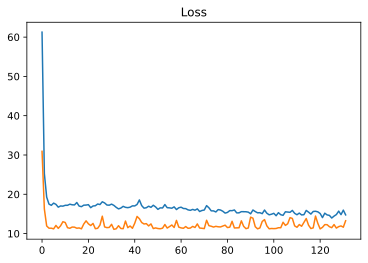

In [72]:
plot_history(history)

## Предсказание и усреднение предсказаний

In [73]:
# Делаем сабмит на модели NLP + Tabular NN
pred_NLP_sub = model.predict([text_sub_sequences, X_sub])[:,0]
sample_submission['price'] = pred_NLP_sub
sample_submission.to_csv('NLP_TabNN_submission.csv', index=False)
display(sample_submission.head())

# Сабмит на усредненных предсказаниях
predict_nn = (pred_RandF_sub + pred_CatBt_sub + pred_XGB_R_sub + pred_NLP_sub)/4
sample_submission['price'] = predict_nn
sample_submission.to_csv('blend_NLP_mean_submission.csv', index=False)
display(sample_submission.head())

,sell_id,price
0,1099427284,742470.000
1,1096405886,2675523.500
2,1100195294,608111.625
3,1099827282,478134.750
4,1100076198,2726418.000


,sell_id,price
0,1099427284,6.395863e+05
1,1096405886,2.562728e+06
2,1100195294,6.709743e+05
3,1099827282,4.880122e+05
4,1100076198,2.674922e+06


Сабмит на модели NLP + Tabular NN дал ошибку 12.12%     
Сабмит на усредненных предсказаниях всех предыдущих моделей дал ошибку 11.11%

Из всех идей для улучшения NLP части:   
* Выделить из описаний часто встречающиеся блоки текста, заменив их на кодовые слова или удалив   
* Сделать предобработку текста, например, сделать лемматизацию - алгоритм ставящий все слова в форму по умолчанию (глаголы в инфинитив и т. д.), чтобы токенайзер не преобразовывал разные формы слова в разные числа    
Статья по теме: https://habr.com/ru/company/Voximplant/blog/446738/    
* Поработать над алгоритмами очистки и аугментации текста    
    
ввиду нехватки времени были использованы только очистка и лемматизация текста.

Без лемматизации метрика ансмбля на сабмите составляла 11.36%, после лемматизации - 11.11%

# Model 5: Добавляем картинки

## Подготовка данных для Image NN

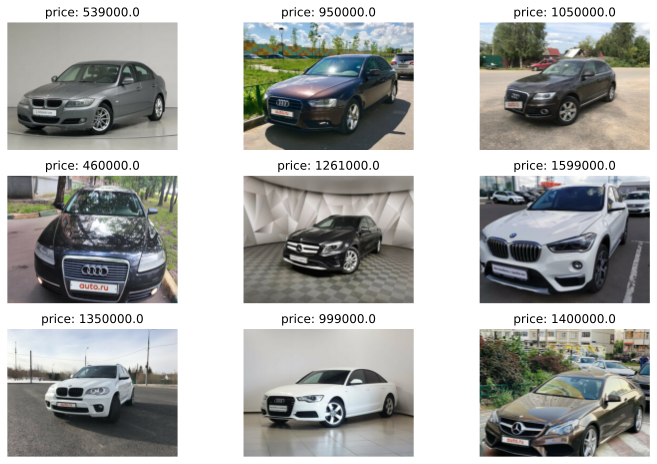

In [74]:
# Убедимся, что цены и фото подгрузились верно
plt.figure(figsize = (12,8))

random_image = train.sample(n = 9)
random_image_paths = random_image['sell_id'].values
random_image_cat = random_image['price'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(DATA_DIR+'img/img/' + str(path) + '.jpg')
    plt.subplot(3, 3, index + 1)
    plt.imshow(im)
    plt.title('price: ' + str(random_image_cat[index]))
    plt.axis('off')
plt.show()

In [75]:
# Функция получения списка изображений с диска
def get_image_array(index):
    images_train = []
    for index, sell_id in enumerate(data['sell_id'].iloc[index].values):
        image = cv2.imread(DATA_DIR + 'img/img/' + str(sell_id) + '.jpg')
        assert(image is not None)
        image = cv2.resize(image, SIZE)
        images_train.append(image)
    images_train = np.array(images_train)
    print('images shape', images_train.shape, 'dtype', images_train.dtype)
    return(images_train)

In [76]:
# Получаем списки изображений для всех наборов данных
images_train = get_image_array(X_train.index)
images_test = get_image_array(X_test.index)
images_sub = get_image_array(X_sub.index)

images shape (5345, 240, 320, 3) dtype uint8
images shape (1337, 240, 320, 3) dtype uint8
images shape (1671, 240, 320, 3) dtype uint8


## Аугментация

In [77]:
# Применим аугментацию с помощью библиотеки Albumentations
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose,
    GaussianBlur, RandomBrightness, CenterCrop, RGBShift, FancyPCA, Resize
)


# Пример взят из официальной документации: https://albumentations.readthedocs.io/en/latest/examples.html
# Правила трансформации для малого размера картинок из документации
transform_base = Compose([
    HorizontalFlip(),
    OneOf([
        IAAAdditiveGaussianNoise(),
        GaussNoise(),
    ], p=0.2),
    OneOf([
        MotionBlur(p=0.2),
        MedianBlur(blur_limit=3, p=0.1),
        Blur(blur_limit=3, p=0.1),
    ], p=0.2),
    ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=1),
    OneOf([
        OpticalDistortion(p=0.3),
        GridDistortion(p=0.1),
        IAAPiecewiseAffine(p=0.3),
    ], p=0.2),
    OneOf([
        CLAHE(clip_limit=2),
        IAASharpen(),
        IAAEmboss(),
        RandomBrightnessContrast(),
    ], p=0.3),
    HueSaturationValue(p=0.3),
], p=1)

# Другие правила трансформации 
transform = Compose([
    GaussianBlur(p=0.05),
    RandomBrightness(limit=0.2, p=0.5),
    ShiftScaleRotate(shift_limit=0.06, 
                       scale_limit=0.01, 
                       interpolation=1, 
                       border_mode=4, 
                       rotate_limit=20, 
                       p=.75),
    OneOf([
        RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3),
        RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1)],
        p=0.5),
    HorizontalFlip(p=0.5),
    HueSaturationValue(p=0.5),
    FancyPCA(alpha=0.1, 
               always_apply=False, 
               p=0.5)
])

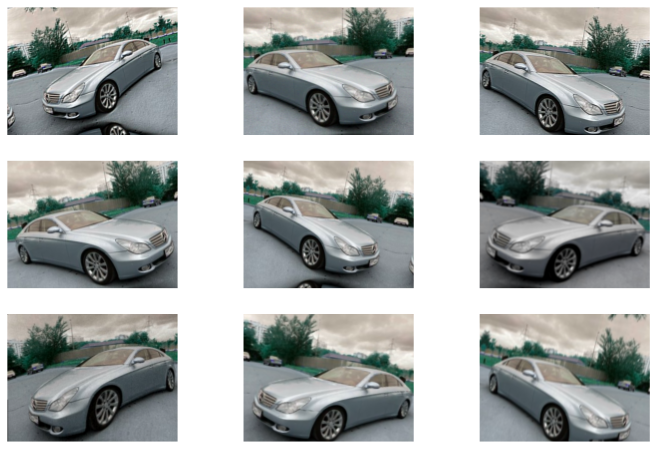

In [78]:
# Примеры аугментированных данных
plt.figure(figsize = (12,8))
for i in range(9):
    img = transform_base(image = images_train[0])['image']
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

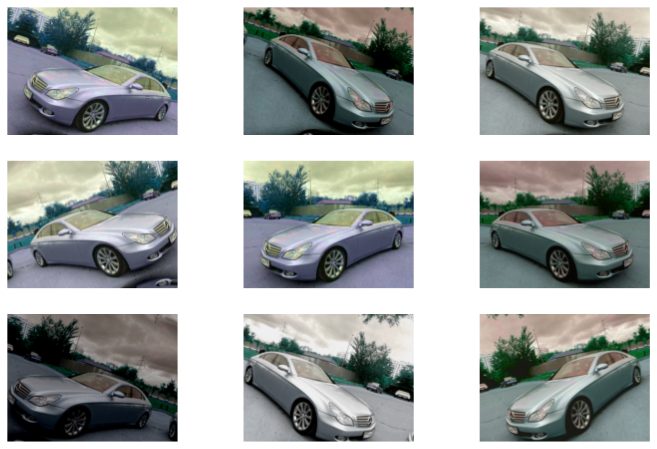

In [79]:
plt.figure(figsize = (12,8))
for i in range(9):
    img = transform(image = images_train[0])['image']
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

Опыты с разными правилами аугментации показали, что аугментация не очень сильно меняла метрику качества. Поэтому в дальнейшем будем использовать правила аугментации, данные в базовом ноутбуке.

## Итератор tf.data.Dataset

<span style="color:teal;">

tf.data.Dataset   
Если все изображения мы будем хранить в памяти, то может возникнуть проблема ее нехватки. Нельзя хранить все изображения в памяти целиком!

Метод .fit() модели keras может принимать либо данные в виде массивов или тензоров, либо разного рода итераторы, из которых наиболее современным и гибким является [tf.data.Dataset](https://www.tensorflow.org/guide/data). Он представляет собой конвейер, то есть мы указываем, откуда берем данные и какую цепочку преобразований с ними выполняем. Далее мы будем работать с tf.data.Dataset.

Dataset хранит информацию о конечном или бесконечном наборе кортежей (tuple) с данными и может возвращать эти наборы по очереди. Например, данными могут быть пары (input, target) для обучения нейросети. С данными можно осуществлять преобразования, которые осуществляются по мере необходимости ([lazy evaluation](https://ru.wikipedia.org/wiki/%D0%9B%D0%B5%D0%BD%D0%B8%D0%B2%D1%8B%D0%B5_%D0%B2%D1%8B%D1%87%D0%B8%D1%81%D0%BB%D0%B5%D0%BD%D0%B8%D1%8F)).

`tf.data.Dataset.from_tensor_slices(data)` - создает датасет из данных, которые представляют собой либо массив, либо кортеж из массивов. Деление осуществляется по первому индексу каждого массива. Например, если `data = (np.zeros((128, 256, 256)), np.zeros(128))`, то датасет будет содержать 128 элементов, каждый из которых содержит один массив 256x256 и одно число.

`dataset2 = dataset1.map(func)` - применение функции к датасету; функция должна принимать столько аргументов, каков размер кортежа в датасете 1 и возвращать столько, сколько нужно иметь в датасете 2. Пусть, например, датасет содержит изображения и метки, а нам нужно создать датасет только из изображений, тогда мы напишем так: `dataset2 = dataset.map(lambda img, label: img)`.

`dataset2 = dataset1.batch(8)` - группировка по батчам; если датасет 2 должен вернуть один элемент, то он берет из датасета 1 восемь элементов, склеивает их (нулевой индекс результата - номер элемента) и возвращает.

`dataset.__iter__()` - превращение датасета в итератор, из которого можно получать элементы методом `.__next__()`. Итератор, в отличие от самого датасета, хранит позицию текущего элемента. Можно также перебирать датасет циклом for.

`dataset2 = dataset1.repeat(X)` - датасет 2 будет повторять датасет 1 X раз.

Если нам нужно взять из датасета 1000 элементов и использовать их как тестовые, а остальные как обучающие, то мы напишем так:

`test_dataset = dataset.take(1000)
train_dataset = dataset.skip(1000)`

Датасет по сути неизменен: такие операции, как map, batch, repeat, take, skip никак не затрагивают оригинальный датасет. Если датасет хранит элементы [1, 2, 3], то выполнив 3 раза подряд функцию dataset.take(1) мы получим 3 новых датасета, каждый из которых вернет число 1. Если же мы выполним функцию dataset.skip(1), мы получим датасет, возвращающий числа [2, 3], но исходный датасет все равно будет возвращать [1, 2, 3] каждый раз, когда мы его перебираем.

tf.Dataset всегда выполняется в graph-режиме (в противоположность eager-режиму), поэтому либо преобразования (`.map()`) должны содержать только tensorflow-функции, либо мы должны использовать tf.py_function в качестве обертки для функций, вызываемых в `.map()`. Подробнее можно прочитать [здесь](https://www.tensorflow.org/guide/data#applying_arbitrary_python_logic).
    
</span>

In [80]:
# NLP part
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data.description)

In [81]:
# Функции для подготовки данных для tf.data.Dataset

# Функция для аугментирования изображения
def process_image(image):
    return transform_base(image = image.numpy())['image']

# Функция для токенизации текста (описания)
def tokenize_(descriptions):
    return sequence.pad_sequences(tokenize.texts_to_sequences(descriptions), maxlen = MAX_SEQUENCE_LENGTH)

# Функция для декодирования токенизированного текста
def tokenize_text(text):
    return tokenize_([text.numpy().decode('utf-8')])[0]

# Функция подачи в нужном формате очередной порции тренировочных данных
def tf_process_train_dataset_element(image, table_data, text, price):
    im_shape = image.shape
    [image,] = tf.py_function(process_image, [image], [tf.uint8])
    image.set_shape(im_shape)
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

# Функция подачи в нужном формате очередной порции валидационных данных
def tf_process_val_dataset_element(image, table_data, text, price):
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

In [82]:
# Готовим данные для модели посредством tf.data.Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((
    images_train, X_train, data.description.iloc[X_train.index], y_train
    )).map(tf_process_train_dataset_element)

test_dataset = tf.data.Dataset.from_tensor_slices((
    images_test, X_test, data.description.iloc[X_test.index], y_test
    )).map(tf_process_val_dataset_element)

y_sub = np.zeros(len(X_sub))
sub_dataset = tf.data.Dataset.from_tensor_slices((
    images_sub, X_sub, data.description.iloc[X_sub.index], y_sub
    )).map(tf_process_val_dataset_element)

In [83]:
# Проверяем, что нет ошибок (не будет выброшено исключение):
train_dataset.__iter__().__next__();
test_dataset.__iter__().__next__();
sub_dataset.__iter__().__next__();

Ошибок нет. Данные можно подавать в нейронную сеть.

## Обучение Image моделей

В качестве предобученной сети для обработки изображений были опробованы и обучены 4 модели:   
* EfficientNetB3    
* EfficientNetB5   
* DenseNet169    
* InceptionResNetV2

Модели были сохранены и добавлены в качестве данных в этот ноутбук.   
Отдельно каждая из моделей давала не очень хороший результат на сабмите - около 12% ошибки. Но затем их этих моделей формировался ансамбль.    
Для быстроты исполнения ячейки с обучением каждой отдельной модели, кроме DenseNet (самой быстрой), взяты в комментарии. Процесс обучения DenseNet раскомментарен для демонстрации работоспособности кода написанного класса.

In [84]:
# Класс работы с нейросетью
class NNet:  
    '''Атрибуты'''
    im_name = 'model'
    model = Model()
        
    '''Конструктор'''
    def __init__(self, im_model_name, tabular_model, nlp_model, image_model=None, inputstr=''):
        im_model = image_model
        if image_model is None:
            im_model = load_model(inputstr)
            
        image_output = L.GlobalAveragePooling2D()(im_model.output)
        
        # Объединяем выходы трех нейросетей
        combinedInput = L.concatenate([image_output, tabular_model.output, nlp_model.output])

        # Надстраиваем голову с выходом
        head = L.Dense(256, activation="relu")(combinedInput)
        head = L.Dense(1,)(head)

        self.model = Model(inputs=[image_model.input, tabular_model.input, nlp_model.input], outputs=head)
        self.im_name = im_model_name
        
        
    '''Методы'''
    
    # история обучения
    def plot_model_history(self, history):
        plot_history(history)
    
    
    # Обучение
    def fit(self, train_dataset, test_dataset, batch, callbacks_list, y_test): 
        # Компилируем модель
        optimizer = tf.keras.optimizers.Adam(0.01)
        self.model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])
        
        # Обучаем
        history = self.model.fit(train_dataset.batch(batch),
                    epochs=10,
                    validation_data = test_dataset.batch(batch),
                    callbacks=callbacks_list
                   )
        
        optimizer = tf.keras.optimizers.Adam(0.001)
        self.model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])
        history = self.model.fit(train_dataset.batch(batch),
                    epochs=10,
                    validation_data = test_dataset.batch(batch),
                    callbacks=callbacks_list
                   )
        
        optimizer = tf.keras.optimizers.Adam(0.0001)
        self.model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])
        history = self.model.fit(train_dataset.batch(batch),
                    epochs=5,
                    validation_data = test_dataset.batch(batch),
                    callbacks=callbacks_list
                   )
        
        # Опытным путем было выяснено, что прямое указание learning rate эффективнее шедулера
        
        self.plot_model_history(history)
        test_predict_nn = self.model.predict(test_dataset.batch(batch))
        print(f"TEST mape: {(mape(y_test, test_predict_nn[:,0]))*100:0.2f}%")
        
    # Сабмит
    def submit(self, sub_dataset, batch):
        sub_predict = self.model.predict(sub_dataset.batch(batch))
        sample_submission['price'] = sub_predict[:,0]
        sample_submission.to_csv(self.im_name+'_nn3_submission.csv', index=False)
        return sub_predict[:,0]

In [85]:
# NN для табличных данных
tabular_model = Sequential()
tabular_model.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
tabular_model.add(L.BatchNormalization())
tabular_model.add(L.Dropout(0.4))
tabular_model.add(L.Dense(256, activation="relu"))
tabular_model.add(L.Dropout(0.4))
tabular_model.add(L.Dense(64, activation="relu"))
tabular_model.add(L.Dropout(0.4))

In [86]:
# NLP для обработки текста
nlp_model = Sequential([
    L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"),
    L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,),
    L.LSTM(256, return_sequences=True),
    L.Dropout(0.5),
    L.LSTM(128, return_sequences=True),
    L.Dropout(0.25),
    L.LSTM(64),
    L.Dropout(0.25),
    L.Dense(32),
    ])

In [87]:
# Настраиваем callback
# Управление шагом обучения вынесено в код класса
checkpoint = ModelCheckpoint('../working/best_model.hdf5', monitor=['val_MAPE'], verbose=1, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=20, restore_best_weights=True,)
   
callbacks_list = [checkpoint, earlystop]

**EfficientNetB3**

In [88]:
# Image NN для обработки изображений. Строится на предобученной модели EfficientNetB3.
# Нормализация включена в состав модели EfficientNetB3, поэтому на вход она принимает данные типа uint8
image_model = tf.keras.applications.efficientnet.EfficientNetB3(
    weights = 'imagenet', 
    include_top = False, 
    input_shape = (SIZE[1], SIZE[0], 3))

Eff3 = NNet('Eff3', tabular_model=tabular_model, nlp_model=nlp_model, image_model=image_model)

43941888/43941136 [==============================] - 0s 0us/step


In [89]:
# # Обучаем
# Eff3.fit(train_dataset, test_dataset, 30, callbacks_list, y_test)

Был попробован метод Fine-Tuning для заморозки и последовательной разморозки слоев предобученной сети EfficientNetB3. Однако никаких выгод это не принесло.   
Ниже приводится код для последовательной разморозки.

In [90]:
# # Разморозка половины слоев
# base_model.trainable = True
# fine_tune_at = len(base_model.layers)//2
# for layer in base_model.layers[:fine_tune_at]:
#     layer.trainable =  False
    
# optimizer = tf.keras.optimizers.Adam(0.05)
# model_eff3.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

# # Разморозка всех слоев
# base_model.trainable = True

# optimizer = tf.keras.optimizers.Adam(0.05)
# model_eff3.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [91]:
# # Делаем сабмит и сохраняем результат предсказания
# pred_Eff3_sub = Eff3.submit(sub_dataset, 30)

**EfficientNetB5**

In [92]:
image_model = tf.keras.applications.efficientnet.EfficientNetB5(
    weights = 'imagenet', 
    include_top = False, 
    input_shape = (SIZE[1], SIZE[0], 3))

Eff5 = NNet('EffB5', tabular_model=tabular_model, nlp_model=nlp_model, image_model=image_model)

115269632/115263384 [==============================] - 1s 0us/step


In [93]:
# # Обучаем
# Eff3.fit(train_dataset, test_dataset, 20, callbacks_list, y_test)

Из-за "тяжелой" модели и большого количества параметров при батче=30 вылетала ошибка переполнения памяти. Батч пришлось уменьшить до 20.

In [94]:
# # Делаем сабмит и сохраняем результат предсказания
# pred_Eff5_sub = Eff5.submit(sub_dataset, 20)

**DenseNet169**

In [95]:
image_model = DenseNet169(
    weights = 'imagenet', 
    include_top = False, 
    input_shape = (SIZE[1], SIZE[0], 3))

DN169 = NNet('DN169', tabular_model=tabular_model, nlp_model=nlp_model, image_model=image_model)

51879936/51877672 [==============================] - 0s 0us/step


Epoch 1/10
179/179 [==============================] - ETA: 0s - loss: 42.6935 - MAPE: 42.6935
Epoch 00001: saving model to ../working/best_model.hdf5
179/179 [==============================] - 94s 527ms/step - loss: 42.6935 - MAPE: 42.6935 - val_loss: 21.7240 - val_MAPE: 21.7240
Epoch 2/10
179/179 [==============================] - ETA: 0s - loss: 21.7312 - MAPE: 21.7312
Epoch 00002: saving model to ../working/best_model.hdf5
179/179 [==============================] - 90s 501ms/step - loss: 21.7312 - MAPE: 21.7312 - val_loss: 15.7552 - val_MAPE: 15.7552
Epoch 3/10
179/179 [==============================] - ETA: 0s - loss: 19.8706 - MAPE: 19.8706
Epoch 00003: saving model to ../working/best_model.hdf5
179/179 [==============================] - 89s 495ms/step - loss: 19.8706 - MAPE: 19.8706 - val_loss: 15.3928 - val_MAPE: 15.3928
Epoch 4/10
179/179 [==============================] - ETA: 0s - loss: 18.5782 - MAPE: 18.5782
Epoch 00004: saving model to ../working/best_model.hdf5
179/179 [=

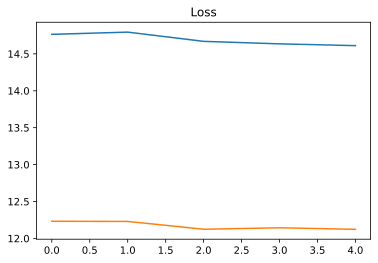

TEST mape: 12.12%


In [96]:
# Обучаем
DN169.fit(train_dataset, test_dataset, 30, callbacks_list, y_test)

In [97]:
# Делаем сабмит и сохраняем результат предсказания
pred_DN169_sub = DN169.submit(sub_dataset, 30)

**InceptionResNetV2**

In [98]:
image_model = inception_resnet_v2.InceptionResNetV2(
    weights = 'imagenet', 
    include_top = False, 
    input_shape = (SIZE[1], SIZE[0], 3))

IRN = NNet('InceptionResNetV2', image_model=image_model, tabular_model=tabular_model, nlp_model=nlp_model)

219062272/219055592 [==============================] - 1s 0us/step


In [99]:
# # Обучаем
# IRN.fit(50, train_dataset, test_dataset, 30, callbacks_list, y_test)

In [100]:
# # Делаем сабмит и сохраняем результат предсказания
# pred_IRN_sub = IRN.submit(sub_dataset, 30)

Данные модели, несмотря на разные ухищрения (изменение правил аугментации, архитектуры сети и шага обучения, подключение разных предобученных сетей) не принесли такого результат, как регрессия CatBoost и нейросеть для обработки только табличных данных. На обучении метрика не опустилась ниже 11.38% (у модели EfficieNetB5), а на сабмите - ниже 12.40%

<span style="color:teal;">

#### Общие рекомендации:
* Попробовать разные архитектуры
* Провести более детальный анализ результатов
* Попробовать различные подходы в управление LR и оптимизаторы
* Поработать с таргетом
* Использовать Fine-tuning

#### Tabular
* В нейросеть желательно подавать данные с распределением, близким к нормальному, поэтому от некоторых числовых признаков имеет смысл взять логарифм перед нормализацией. Пример:
`modelDateNorm = np.log(2020 - data['modelDate'])`
Статья по теме: https://habr.com/ru/company/ods/blog/325422

* Извлечение числовых значений из текста:
Парсинг признаков 'engineDisplacement', 'enginePower', 'Владение' для извлечения числовых значений.

* Cокращение размерности категориальных признаков
Признак name 'name' содержит данные, которые уже есть в других столбцах ('enginePower', 'engineDisplacement', 'vehicleTransmission'). Можно удалить эти данные. Затем можно еще сильнее сократить размерность, например выделив наличие xDrive в качестве отдельного признака.

* Поработать над Feature engineering



#### NLP
* Выделить из описаний часто встречающиеся блоки текста, заменив их на кодовые слова или удалив
* Сделать предобработку текста, например сделать лемматизацию - алгоритм ставящий все слова в форму по умолчанию (глаголы в инфинитив и т. д.), чтобы токенайзер не преобразовывал разные формы слова в разные числа
Статья по теме: https://habr.com/ru/company/Voximplant/blog/446738/
* Поработать над алгоритмами очистки и аугментации текста



#### CV
* Попробовать различные аугментации
* Fine-tuning
    
</span>

# Ансамбль всех моделей

In [101]:
# Загрузим все полученные модели
EffB3 = load_model('../input/cnn-rnn-1163/cnn_rnn_1163.hdf5')
EffB5 = load_model('../input/eff5-1138/eff5_1138.hdf5')
DN169 = load_model('../input/dn169-1143/dn169_1143.hdf5')
IRNv2 = load_model('../input/irn-1146/irn_1146.hdf5')
# TabNN = load_model('../input/tabular-nn-1100/tabular 1100_nn.hdf5')

In [102]:
TabNN = model_tnn

In [103]:
# Сделаем предсказания для train
pred_EffB3_tr = EffB3.predict(train_dataset.batch(30)).reshape(-1,1)
pred_EffB5_tr = EffB5.predict(train_dataset.batch(20)).reshape(-1,1)
pred_DN169_tr = DN169.predict(train_dataset.batch(30)).reshape(-1,1)
pred_IRNv2_tr = IRNv2.predict(train_dataset.batch(30)).reshape(-1,1)
pred_TabNN_tr = TabNN.predict(X_train).reshape(-1,1)
pred_RandF_tr = pred_RandF_tr.reshape(-1,1)
pred_CatBt_tr = pred_CatBt_tr.reshape(-1,1)
pred_XGB_R_tr = pred_XGB_R_tr.reshape(-1,1)

In [104]:
# Сделаем предсказания для test
pred_EffB3_tt = EffB3.predict(test_dataset.batch(30)).reshape(-1,1)
pred_EffB5_tt = EffB5.predict(test_dataset.batch(20)).reshape(-1,1)
pred_DN169_tt = DN169.predict(test_dataset.batch(30)).reshape(-1,1)
pred_IRNv2_tt = IRNv2.predict(test_dataset.batch(30)).reshape(-1,1)
pred_TabNN_tt = TabNN.predict(X_test).reshape(-1,1)
pred_RandF_tt = pred_RandF_tt.reshape(-1,1)
pred_CatBt_tt = pred_CatBt_tt.reshape(-1,1)
pred_XGB_R_tt = pred_XGB_R_tt.reshape(-1,1)

In [105]:
# Составим обучающие мета-данные для линейной регрессии
meta_train = np.hstack([
    pred_EffB3_tr, 
    pred_EffB5_tr,
    pred_DN169_tr,
    pred_IRNv2_tr,
    pred_TabNN_tr,
    pred_RandF_tr,
    pred_CatBt_tr,
    pred_XGB_R_tr
])

meta_test = np.hstack([
    pred_EffB3_tt, 
    pred_EffB5_tt,
    pred_DN169_tt,
    pred_IRNv2_tt,
    pred_TabNN_tt,
    pred_RandF_tt,
    pred_CatBt_tt,
    pred_XGB_R_tt
])

In [106]:
# Мета-модель линейной регрессии
lreg = LinearRegression()
lreg.fit(meta_train, y_train)
meta_test_predict = lreg.predict(meta_test)
print(f"TEST mape: {(mape(y_test, meta_test_predict))*100:0.2f}%")
coeff = lreg.coef_
coeff

TEST mape: 2.30%


array([-0.00580223,  0.00097566,  0.01601097, -0.00570478, -0.02919585,
        0.02112747,  0.51177004,  0.51177004])

In [107]:
# Мета-модель CatBoost
meta_CatBt = CatBoostRegressor(iterations = 5000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                         )
meta_CatBt.fit(meta_train, np.log(y_train),
         verbose_eval=0
         #plot=True
         )

meta_test_predict = np.exp(meta_CatBt.predict(meta_test))
print(f"TEST MAPE: {(mape(y_test, meta_test_predict))*100:0.2f}%")
coeff = meta_CatBt.feature_importances_
coeff

TEST MAPE: 2.22%


array([ 6.51290043,  4.42522028,  4.92111991,  5.5402259 ,  7.59520934,
       19.06854833, 27.30290374, 24.63387205])

Коэффициенты meta CatBoost больше похожи на правду. Воспользуемся ими.

In [108]:
# Проверим точность ансамбля на валидационных денных
blend_predict= (coeff[0]*pred_EffB3_tt[:,0] + \
                coeff[1]*pred_EffB5_tt[:,0] + \
                coeff[2]*pred_DN169_tt[:,0] + \
                coeff[3]*pred_IRNv2_tt[:,0] + \
                coeff[4]*pred_TabNN_tt[:,0] + \
                coeff[5]*pred_RandF_tt[:,0] + \
                coeff[6]*pred_CatBt_tt[:,0] + \
                coeff[7]*pred_XGB_R_tt[:,0]) 
print(f"TEST mape: {(mape(y_test, blend_predict))*100:0.2f}%")

TEST mape: 10399.69%


In [109]:
# Предсказываем всеми моделями
pred_EffB3_sub = EffB3.predict(sub_dataset.batch(30)).reshape(-1,1)
pred_EffB5_sub = EffB5.predict(sub_dataset.batch(20)).reshape(-1,1)
pred_DN169_sub = DN169.predict(sub_dataset.batch(30)).reshape(-1,1)
pred_IRNv2_sub = IRNv2.predict(sub_dataset.batch(30)).reshape(-1,1)
pred_TabNN_sub = TabNN.predict(X_sub).reshape(-1,1)
pred_RandF_sub = pred_RandF_sub.reshape(-1,1)
pred_CatBt_sub = pred_CatBt_sub.reshape(-1,1)
pred_XGB_R_sub = pred_CatBt_sub.reshape(-1,1)

In [110]:
# Делаем сабмит на бленде, основанном на коэффициентах регрессии
blend_sub_predict= (coeff[0]*pred_EffB3_sub[:,0] + \
                    coeff[1]*pred_EffB5_sub[:,0] + \
                    coeff[2]*pred_DN169_sub[:,0] + \
                    coeff[3]*pred_IRNv2_sub[:,0] + \
                    coeff[4]*pred_TabNN_sub[:,0] + \
                    coeff[5]*pred_RandF_sub[:,0] + \
                    coeff[6]*pred_CatBt_sub[:,0] + \
                    coeff[7]*pred_XGB_R_sub[:,0]) 
sample_submission['price'] = blend_sub_predict
sample_submission.to_csv('multi_blend_submission.csv', index=False)

In [111]:
# Делаем сабмит на усредненных данных
blend_sub_predict= (pred_EffB3_sub[:,0] + \
                    pred_EffB5_sub[:,0] + \
                    pred_DN169_sub[:,0] + \
                    pred_IRNv2_sub[:,0] + \
                    pred_TabNN_sub[:,0] + \
                    pred_RandF_sub[:,0] + \
                    pred_CatBt_sub[:,0] + \
                    pred_XGB_R_sub[:,0])/8
sample_submission['price'] = blend_sub_predict
sample_submission.to_csv('multi_mean_submission.csv', index=False)

# Model Bonus: проброс признака

In [112]:
# CatBt_features = ['age_log', 'model_age_log', 'mileage_norm_log', 'eP_log']
CatBt_features = ['age_log', 'eP_log', 'model_age_log']

In [113]:
# MLP
model_mlp = Sequential(name='MLP')

model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation='relu'))
model_mlp.add(L.BatchNormalization())
model_mlp.add(L.Dropout(0.4, seed=RANDOM_SEED))

model_mlp.add(L.Dense(256, activation='relu'))
model_mlp.add(L.Dropout(0.4, seed=RANDOM_SEED))

model_mlp.add(L.Dense(128, activation='relu'))
model_mlp.add(L.Dropout(0.4, seed=RANDOM_SEED))

In [114]:
# Проброс признаков
model_for = Sequential(name='Forwarding')
model_for.add(L.Input(shape=[len(CatBt_features)]))

In [115]:
# Комбинируем две модели и надстраиваем голову
combinedInput = L.concatenate([model_mlp.output, model_for.output])

head = L.Dense(128, activation='relu')(combinedInput)
head = L.BatchNormalization()(head)
head = L.Dropout(0.4,seed=RANDOM_SEED)(head)

head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)

model = Model(inputs=[model_mlp.input, model_for.input], outputs=head)

In [116]:
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [117]:
history = model.fit([X_train, X_train[CatBt_features]], y_train,
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=([X_test, X_test[CatBt_features]], y_test),
                    callbacks=callbacks_list
                   )

Epoch 1/500
 1/11 [=>............................] - ETA: 0s - loss: 100.0001 - MAPE: 100.0001
Epoch 00001: saving model to ../working/best_model.hdf5
11/11 [==============================] - 0s 22ms/step - loss: 99.8896 - MAPE: 99.8896 - val_loss: 99.6148 - val_MAPE: 99.6148
Epoch 2/500
 1/11 [=>............................] - ETA: 0s - loss: 98.8616 - MAPE: 98.8616
Epoch 00002: saving model to ../working/best_model.hdf5
11/11 [==============================] - 0s 9ms/step - loss: 90.7169 - MAPE: 90.7169 - val_loss: 80.7736 - val_MAPE: 80.7736
Epoch 3/500
 1/11 [=>............................] - ETA: 0s - loss: 79.1160 - MAPE: 79.1160
Epoch 00003: saving model to ../working/best_model.hdf5
11/11 [==============================] - 0s 9ms/step - loss: 71.2799 - MAPE: 71.2799 - val_loss: 61.1700 - val_MAPE: 61.1700
Epoch 4/500
 1/11 [=>............................] - ETA: 0s - loss: 59.8755 - MAPE: 59.8755
Epoch 00004: saving model to ../working/best_model.hdf5
11/11 [===================

In [118]:
test_predict_nn_bonus = model.predict([X_test, X_test[CatBt_features].values])
print(f"TEST mape: {(mape(y_test, test_predict_nn_bonus[:,0]))*100:0.2f}%")

TEST mape: 11.14%


In [119]:
sub_predict_nn_bonus = model.predict([X_sub, X_sub[CatBt_features].values])

In [120]:
# Делаем сабмит на усредненных данных
blend_sub_predict= (sub_predict_nn_bonus.reshape(-1,1)[:,0] + \
                    pred_TabNN_sub.reshape(-1,1)[:,0] + \
                    pred_CatBt_sub.reshape(-1,1)[:,0] + \
                    pred_XGB_R_sub.reshape(-1,1)[:,0])/4
sample_submission['price'] = blend_sub_predict
sample_submission.to_csv('bonus_mean_submission.csv', index=False)

sample_submission.head()

,sell_id,price
0,1099427284,7.853071e+05
1,1096405886,3.136886e+06
2,1100195294,7.694151e+05
3,1099827282,5.690888e+05
4,1100076198,3.214744e+06


Сабмит на усредненных данных для этих моделей принес неплохой результат: 10.90%.

# Выводы по проекту

**В ходе проекта были опробованы нейронные сети:**    
* для обработки табличных данных (MLP) и сравнения с обычными моделями регрессии;    
* для обработки текстовых данных (NLP);   
* для объединения выходов нескольких сетей разного вида, в том числе для конкатенирования сверточной сети для обработки изображений CNN, MLP и NLP;   
* для проброски важных признаков напрямую в нейросеть.   
    
**Результаты применения разных нейросетей показали:**   
* "чистая" регрессия CatBoost или XGB с тщательно подобранными гиперпараметрами выдает примерно равный результат для Tabular NN, то есть для многослойного перцептрона (MLP). Лучший результат для этих моделей на сабмите - примерно 11.2%-11.3%    
* "чистая" модель NLP дала не очень хороший результат - около 12.4%. Возможно, недостаточно полно был обработан признак с описанием автомобиля;    
* "чистая" одиночная модель для обработки изображений CNN дала всего лишь 11.78%    
   
**Упор в достижении результата делался на ансамблирование моделей.** В качестве ансамблей предсказания одиночных моделей использовались в виде:    
* простого усреднения предсказаний;    
* построения мета-модели регрессии из отдельных предсказаний.    

**Результаты ансамблирования таковы:**    
* Простое среднее трех моделей регрессии (RandomForest, CatBoost, XGB) дало на сабмите результат 11.169%. Взвешенная сумма предсказаний этих моделей с весами, полученными регрессией мета-модели, дал чуть лучший результат - 11.165%
* Простое усреднение предсказаний трех моделей регрессии с предсказанием Tabular NN (MLP) дал неплохой результат 10.96% Мета-модель регрессии почему-то ухудшило эту метрику и на сабмите принесла 11.00%   
* Ансамбль из трех регрессий, MLP и NLP чуть-чуть улучшил метрику до 10.95%
* Для обработки изображений были обучены 4 разные готовые модели: IceptionResNetV2, EfficientNetB3, EfficientNetB5, DenseNet169. Их ансамбль в виде простого среднего принес на сабмите результат 11.25%.    
* Ансамбль из предсказаний всех возможных моделей, включая модель с пробросом признаков, принес результат 10.90%   
     
**Были применены способы улучшения метрики:**    
* При очистке исходных данных был сгенерирован дополнительный датасет со статистиками (среднее, медиана, максимум, минимум, стандартное отклонение) по каждому числовому признаку с группировкой по отдельным значениям категориальных признаков;    
* Для моделей регрессии были подобраны гипер-параметры;    
* Модели регрессии обучались на полных данных без выделения на train и test;     
* В нейросетях использовался механизм Reduce Learning Rate;
* Текстовые данные подверглись обработке: был проведен tf-idf анализ и признаки, сниженные до размерности 2, были включены в датасет для обучения. Столбцы tfidf1 и tfidf2 оказались весьма значимы для обучения;
* Текстовые данные подверглись обработке: был проведен анализ тональности, признаки с оценкой тональности и субъективностью были включены в датасет для обучения.   
* Текстовые данные подверглись обработке: была проведена токенизация и лемматизация; из текста были выброшены русские стоп-слова;   
* Архитектура нейросетей была доработана в виде добавления дополнительных слоев и батч-нормализации.    

**Итог**    

Результатом таких доработок стал сабмит с метрикой 10.79366%. Он был достигнут обучением регрессий на полных данных и ансамблированием регрессий и Tabular NN в виде простого усреднения. На момент сдачи проекта это 7 место из 80.    
     
Ансамблирование тех же моделей с добавлением проброса признака принесло результат 10.80167%, что примерно соответствует погрешности первого лучшего результата.    
     
К сожалению, ансамбли, включающие NLP с обработкой текста и CNN с обработкой изображений, только ухудшали метрику. Также не помог и Fine-Tuning с постепенной разморозкой предобученных сетей IceptionResNetV2, EfficientNetB3, EfficientNetB5, DenseNet169. Возможно, плохо была подобрана аугментация или же мало было данных.